# Finetune: plot validation results on random init CNN and original prepared dataset

We now explore the output of the finetuning on physionet dataset which is set up by this notebook in the `master` branch of the project repo.

> `jupyter_notebooks/finetune_train_random_original.ipynb`

To recap, we use the physionet dataset sampled at 250 hz, 65 seconds. We set aside 5% of the total dataset for validation dataset.

* Note: in finetuning trainer, the validation set size is a function of the train set size, which is 80% of the total dataset size. Thus, the authors set validation to be 6.25% of the train set size.

We train on an uninitialized network.

Thanks to Myles help we are able to get an initial round of results. Caveat: it is produced on a validation set that's less than 5% of the total size due to `--val-size 0.05` being used, when 0.0625 should have been used.

Nevertheless, we can still explore the results.

In [ ]:
# You may also manually mount drive by clicking on folder icon in left sidebar
# from google.colab import drive
# drive.mount('/content/drive')

In [1]:
PROJECT_ROOT = '/content/drive/MyDrive/DLHProject'

In [2]:
REPO = PROJECT_ROOT + '/Danielgitrepo'

In [3]:
%cd $REPO

/content/drive/.shortcut-targets-by-id/1vlUILM7cToH5CoX1x0kWRpe55MbBogS-/Project/Danielgitrepo


In [4]:
%%capture
! pip install -r requirements.txt

In [7]:
JOB_DIR = PROJECT_ROOT + '/jobs'

In [8]:
! ls $JOB_DIR

finetune_random_cnn_original_data


The output of the finetuning train job can be seen below:

In [9]:
! ls $JOB_DIR/finetune_random_cnn_original_data

best_model.weights.data-00000-of-00001	checkpoint   test_predictions.csv   val_predictions.csv
best_model.weights.index		history.csv  train_predictions.csv


First we shall run the test set evaluation routine as described in finetuning/readme.md

In [10]:
from transplant.evaluation import f1
from transplant.utils import read_predictions
test = read_predictions(f'{JOB_DIR}/finetune_random_cnn_original_data/test_predictions.csv')
y_true = test['y_true']
y_prob = test['y_prob']
print(f1(y_true, y_prob))

0.7180218152145887


Now we try to understand the format of the test_predictions csv file.

In [11]:
import pandas as pd

In [12]:
test_preds = pd.read_csv(f'{JOB_DIR}/finetune_random_cnn_original_data/test_predictions.csv')

In [13]:
test_preds.head()

,record_name,true_A,true_N,true_O,true_~,prob_A,prob_N,prob_O,prob_~
0,A04412,0,1,0,0,0.007207,0.928493,0.059442,0.004857
1,A08158,0,1,0,0,0.000665,0.895624,0.092817,0.010894
2,A01316,0,0,1,0,0.005623,0.000481,0.993269,0.000627
3,A08212,0,1,0,0,0.000763,0.178406,0.820823,0.000008
4,A06581,0,1,0,0,0.062490,0.593710,0.154717,0.189084


Here I'm just debugging how `read_predictions` works as the source code is a bit confusing.

The idea is that we collect the `true_x` columns and extract a N x 4 matrix and store that under the `y_true` key in the output dict object. Similar story for `y_prob` key and the `prob_x` columns.

In [18]:
df = test_preds
classes = [label[5:] for label in df.columns if label.startswith('prob')]
classes
predictions = {}
for prefix in ['true', 'pred', 'prob']:
    col_names = ['{}_{}'.format(prefix, label) for label in classes]
    print(f'colnames: {col_names}')
    col_names = [name for name in col_names if name in df.columns]
    print(f'colnames after pass: {col_names}')
    if col_names:
        predictions['y_{}'.format(prefix)] = df[col_names].values
predictions['classes'] = classes
predictions

colnames: ['true_A', 'true_N', 'true_O', 'true_~']
colnames after pass: ['true_A', 'true_N', 'true_O', 'true_~']
colnames: ['pred_A', 'pred_N', 'pred_O', 'pred_~']
colnames after pass: []
colnames: ['prob_A', 'prob_N', 'prob_O', 'prob_~']
colnames after pass: ['prob_A', 'prob_N', 'prob_O', 'prob_~']


{'y_true': array([[0, 1, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, 0],
        ...,
        [0, 1, 0, 0],
        [0, 1, 0, 0],
        [0, 1, 0, 0]]),
 'y_prob': array([[7.2069177e-03, 9.2849350e-01, 5.9442230e-02, 4.8573940e-03],
        [6.6501370e-04, 8.9562380e-01, 9.2817195e-02, 1.0893983e-02],
        [5.6227744e-03, 4.8084187e-04, 9.9326940e-01, 6.2696025e-04],
        ...,
        [2.1664273e-02, 7.7973604e-01, 6.6423600e-02, 1.3217601e-01],
        [5.7053100e-02, 4.0420124e-01, 1.0886057e-01, 4.2988510e-01],
        [9.9263770e-04, 9.2834830e-01, 7.0399300e-02, 2.5974514e-04]]),
 'classes': ['A', 'N', 'O', '~']}

Now we explore history.csv see if give us useful result

In [20]:
history = pd.read_csv(f'{JOB_DIR}/finetune_random_cnn_original_data/history.csv')

In [21]:
history.head()

,epoch,acc,loss,val_acc,val_loss
0,0,0.604167,0.966750,0.666667,0.825402
1,1,0.680093,0.747196,0.324561,1.115436
2,2,0.709877,0.690747,0.754386,0.688382
3,3,0.732099,0.639388,0.733918,0.676618
4,4,0.752932,0.614576,0.774854,0.627502


## Note

I used "View recommended plots" helper tool to generate the plotting code to make the following 4 plots.

**remark** I do NOT believe these plots are what we are looking for to reproduce Fig 3 in the paper. Specifically F1 score.

I think perhaps the source code is missing a metric for f1 that will be run on the validation set and thus captured in `history.csv`?

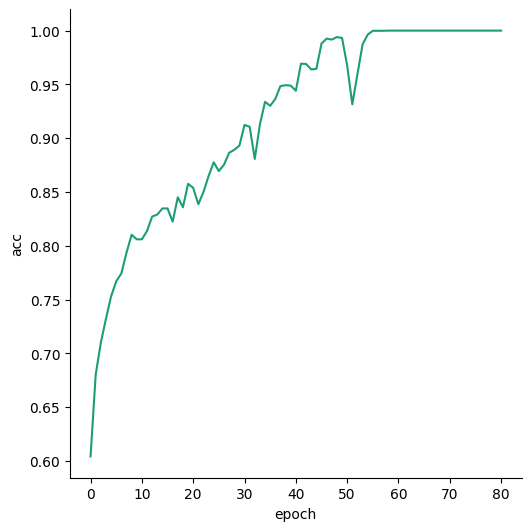

In [26]:
# @title epoch vs acc

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['epoch']
  ys = series['acc']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(5.2, 5.2), layout='constrained')
df_sorted = history.sort_values('epoch', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('epoch')
_ = plt.ylabel('acc')

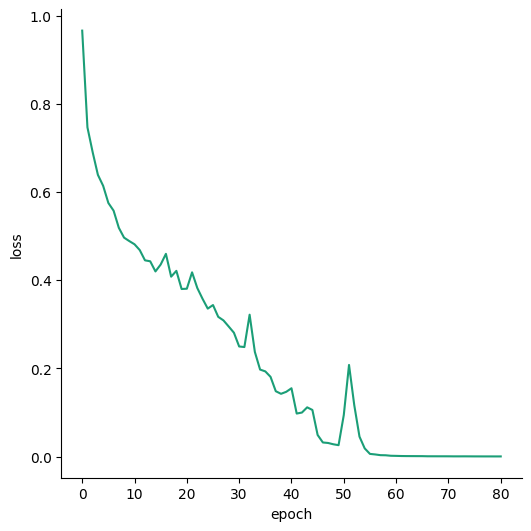

In [27]:
# @title epoch vs loss

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['epoch']
  ys = series['loss']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(5.2, 5.2), layout='constrained')
df_sorted = history.sort_values('epoch', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('epoch')
_ = plt.ylabel('loss')

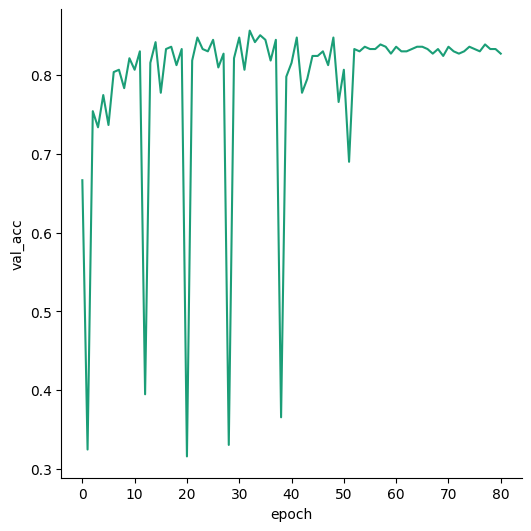

In [28]:
# @title epoch vs val_acc

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['epoch']
  ys = series['val_acc']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(5.2, 5.2), layout='constrained')
df_sorted = history.sort_values('epoch', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('epoch')
_ = plt.ylabel('val_acc')

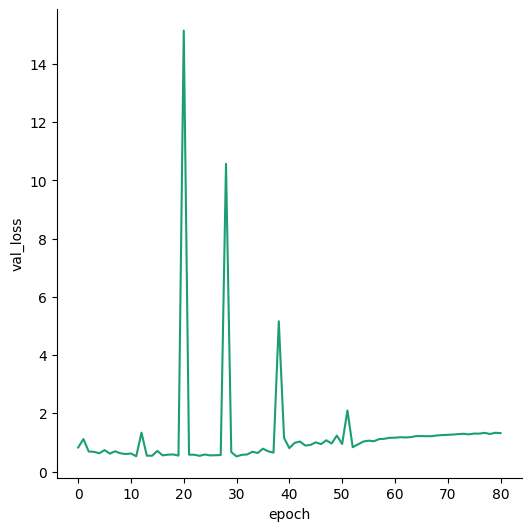

In [29]:
# @title epoch vs val_loss

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['epoch']
  ys = series['val_loss']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(5.2, 5.2), layout='constrained')
df_sorted = history.sort_values('epoch', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('epoch')
_ = plt.ylabel('val_loss')